In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random
import pandas as pd
import scipy.stats
from scipy.io import wavfile
from scipy.spatial.distance import cdist

In [2]:
path_music = './speech_music_classification/train/music'
path_speech = './speech_music_classification/train/speech'

In [3]:
files_music = os.listdir(path_music)
files_speech = os.listdir(path_speech)

In [4]:
# FUNCTION TO COMPUTE THE SPECTROGRAM OF AN AUDIO SAMPLE
def spectrogram(freq, signal ,window_size, shift, dft_point):
    sample_size = int((len(signal) - freq*window_size)/(freq*shift) + 1)
    spec = np.zeros((int(dft_point/2),sample_size),dtype=complex)
    for i in range(sample_size):
        sample = np.fft.fft(np.hamming(400)*signal[int(i*shift*freq):int(i*shift*freq) + int(window_size*freq)], dft_point)
        spec[:,i] = sample[0:int(dft_point/2)]
    spec = np.absolute(spec)
    spec = np.log(spec)
    return spec

In [5]:
window_size = 0.025
shift = 0.010
dft_point = 64
a = 32
b = 2998
total_samples = len(files_music)
music = np.zeros((b * total_samples, a))
speech = np.zeros((b * total_samples, a))

In [6]:
# THIS BLOCK OF CODE COMPUTES THE SPECTROGRAM OF ALL THE MUSIC AND SPEECH FILES
# AND STORES ALL THE FRAMES OBTAINED IN TWO MATRICES
for i in range(total_samples):
    freq, signal = wavfile.read(path_music + '/' + files_music[i])
    spec = spectrogram(freq, signal, window_size, shift, dft_point)
    spec = spec.T
    music[b * i: b * (i+1), :] = spec

for i in range(total_samples):
    freq, signal = wavfile.read(path_speech + '/' + files_speech[i])
    spec = spectrogram(freq, signal, window_size, shift, dft_point)
    spec = spec.T
    speech[b * i:b * (i+1), :] = spec

In [7]:
music.shape

(119920, 32)

In [8]:
speech.shape

(119920, 32)

In [9]:
# FUNCTION TO CALCULATE LOG LIKELIHOOD
def calc_loglikelihood(x, pis, means, cov):
    N = x.shape[0]
    d = x.shape[1]
    ll = np.array([pis[j] * scipy.stats.multivariate_normal(means[j], cov[j], allow_singular=True).pdf(x) for j in range(mix)])
    ll_sum = np.sum(ll, axis=0)
    log_ll = np.log(ll_sum)
    log_ll_sum = (1/N)*np.sum(log_ll)
    return log_ll_sum

# FUNCTION TO CALCULATE RESPONSIBILITY
def calc_responsibility(x, pis, means, cov):
    N = x.shape[0]
    d = x.shape[1]
    resp = np.array([pis[j] * scipy.stats.multivariate_normal(means[j], cov[j], allow_singular=True).pdf(x) for j in range(mix)]).T
    resp = resp.reshape((N, mix))
    resp_sum = np.sum(resp, axis=1)
    resp_sum = resp_sum.reshape((N, 1))
    resp = resp/resp_sum
    return resp

# FUNCTION TO CALCULATE Nk
def calc_Nk(resp):
    Nk = np.sum(resp, axis=0)
    Nk = Nk.reshape((mix, 1))
    return Nk

# FUNCTION TO UPDATE THE WEIGHTS / PRIOR PROBABILITIES
def update_weights(Nk, N):
    pis = Nk/N
    return pis

# FUNCTION TO UPDATE THE MEANS
def update_means(x, resp, Nk):
    means = (np.dot(resp.T, x))/Nk
    return means

# FUNCTION TO UPDATE THE COVARIANCE MATRIX
def update_cov_matrix(x, resp, means, Nk, cov_type):
    N = x.shape[0]
    d = x.shape[1]
    cov = [np.sum(np.array([resp[i][j] * np.dot((x[i] - means[j]).reshape((d, 1)), (x[i] - means[j]).reshape((d, 1)).T) for i in range(N)]), axis=0) for j in range(mix)]
    cov = np.array(cov)
    if(cov_type == 'diag'):
        cov = np.array([np.diag(np.diag(cov[i])) for i in range(mix)])
    cov = np.array([cov[i]/Nk[i] for i in range(mix)])
    return cov


# FUNCTION TO FIND K-MEANS CLUSTER CENTROIDS AND LABELS FOR EACH SAMPLE
def kmeans(x, mix, itr):
    N = x.shape[0]
    idx = np.random.choice(N, mix)
    centroids = x[idx, :]
    distances = cdist(x, centroids ,'euclidean')
    labels = np.array([np.argmin(i) for i in distances])
    for _ in range(itr):
        centroids = []
        for idx in range(mix):
            temp = x[labels==idx].mean(axis=0) 
            centroids.append(temp)
        centroids = np.vstack(centroids)
        distances = cdist(x, centroids ,'euclidean')
        labels = np.array([np.argmin(i) for i in distances])
    return centroids, labels


# FUNCTION FOR OBTAINING GMM PARAMETERS/ EM ALGORITHM
def gmm(x, itr, mix, cov_type):
    N = x.shape[0]
    d = x.shape[1]
    # K-MEANS INITIALIZATION
    means, labels = kmeans(x, mix, 50)
    
    # INITIALIZE WEIGHTS, MEANS, AND COVARIANCE MATRICES
    cov = []
    pis = []
    
    for i in range(mix):
        dat = x[labels == i].T
        p = dat.shape[1]/N
        dat = (1/p) * np.cov(dat)
        cov.append(dat)
        pis.append(p)
    
    cov = np.array(cov)
    pis = np.array(pis)
    
    # RUN EM-ALGORITHM FOR GIVEN NO. OF ITERATIONS
    log_likelihood = []
    for itr in range(itr):
        # E - STEP
        resp = calc_responsibility(x, pis, means, cov)
        # M - STEP
        Nk = calc_Nk(resp)
        pis = update_weights(Nk, N)
        means = update_means(x, resp, Nk)
        cov = update_cov_matrix(x, resp, means, Nk, cov_type)
        log_likelihood.append(calc_loglikelihood(x, pis, means, cov))
        print('Log Likelihood = ' + str(log_likelihood[-1]))

    return pis, means, cov, log_likelihood

In [10]:
# THE INPUT HYPER-PARAMETERS FOR EM ALGORITHMS
itr = 100
mix = 5
cov_type = 'full'

In [11]:
# RUN EM ALGORITHM
music_pis, music_means, music_cov, music_log_likelihood = gmm(music, itr, mix, cov_type)

Log Likelihood = -29.353457894825528
Log Likelihood = -28.133670595904515
Log Likelihood = -27.22274057002937
Log Likelihood = -26.556040324287466
Log Likelihood = -26.108756928460718
Log Likelihood = -25.81903302038141
Log Likelihood = -25.618407008294543
Log Likelihood = -25.46984146982825
Log Likelihood = -25.346239298093675
Log Likelihood = -25.230510124120084
Log Likelihood = -25.11578138588574
Log Likelihood = -24.999200061448086
Log Likelihood = -24.879759242804372
Log Likelihood = -24.7609360487787
Log Likelihood = -24.646680685169255
Log Likelihood = -24.538563596868748
Log Likelihood = -24.437735741717848
Log Likelihood = -24.348366181158337
Log Likelihood = -24.274565297728955
Log Likelihood = -24.2144892935224
Log Likelihood = -24.162725492807375
Log Likelihood = -24.116221102492357
Log Likelihood = -24.075261144328483
Log Likelihood = -24.04054654064705
Log Likelihood = -24.012548826408185
Log Likelihood = -23.990379152318386
Log Likelihood = -23.97275965976343
Log Likelih

In [12]:
music_pis

array([[0.1153941 ],
       [0.27864629],
       [0.19029382],
       [0.35975535],
       [0.05591044]])

In [13]:
music_means

array([[8.51107964, 8.60014393, 8.32843981, 7.88588945, 7.50750458,
        7.23722595, 7.03935144, 6.84013082, 6.65979828, 6.53006334,
        6.39725765, 6.29711062, 6.20045144, 6.12040994, 6.04289544,
        5.97403514, 5.91393737, 5.85802084, 5.81154974, 5.76857049,
        5.72899662, 5.6949777 , 5.66666867, 5.63977726, 5.61656019,
        5.59491881, 5.57983789, 5.56543136, 5.55328248, 5.54452696,
        5.53753011, 5.53100461],
       [8.61718606, 8.55685718, 8.37257767, 7.96885378, 7.68343746,
        7.49313226, 7.3656558 , 7.26899067, 7.1609757 , 7.04945861,
        6.97296693, 6.83534205, 6.70119782, 6.61186286, 6.45594613,
        6.35411919, 6.19199521, 6.04744899, 5.95703433, 5.87316684,
        5.81423608, 5.76133765, 5.71606542, 5.65891127, 5.64008195,
        5.6051982 , 5.58320608, 5.55478408, 5.54305037, 5.51841115,
        5.49824294, 5.42861235],
       [8.47289554, 8.60769501, 8.53759391, 8.07075206, 7.71843429,
        7.52987177, 7.37972797, 7.26397588, 7.1320

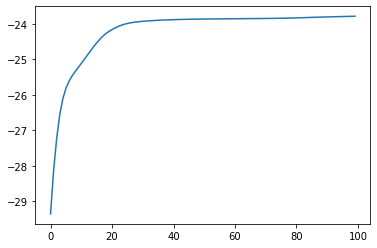

In [14]:
plt.plot(music_log_likelihood)

In [15]:
# THE INPUT HYPER-PARAMETERS FOR EM ALGORITHMS
itr = 75
mix = 5
cov_type = 'full'

In [16]:
#RUN EM ALGORITHM
speech_pis, speech_means, speech_cov, speech_log_likelihood = gmm(speech, itr, mix, cov_type)

Log Likelihood = -31.74726563376108
Log Likelihood = -19.659795926739925
Log Likelihood = -28.84330098860184
Log Likelihood = -28.582962161522072
Log Likelihood = -28.42839646495327
Log Likelihood = -28.266847255720847
Log Likelihood = -28.124979445179005
Log Likelihood = -28.024790547024715
Log Likelihood = -27.953053432348742
Log Likelihood = -27.89074750126137
Log Likelihood = -27.83838719598022
Log Likelihood = -27.7987108982226
Log Likelihood = -27.768337085114553
Log Likelihood = -27.744676574251386
Log Likelihood = -27.726735436249054
Log Likelihood = -27.713940854968516
Log Likelihood = -27.705277181428343
Log Likelihood = -27.69941595199331
Log Likelihood = -27.695323226553228
Log Likelihood = -27.692332316512765
Log Likelihood = -27.69004446264925
Log Likelihood = -27.688211393596283
Log Likelihood = -27.68667492902041
Log Likelihood = -27.68533206448952
Log Likelihood = -27.6841130881811
Log Likelihood = -27.682968495404104
Log Likelihood = -27.68186221702266
Log Likelihood 

In [17]:
speech_pis

array([[0.08454871],
       [0.04493112],
       [0.08211542],
       [0.17178253],
       [0.61662222]])

In [18]:
speech_means

array([[8.17693039, 7.69072011, 7.12405529, 6.64658999, 6.33392112,
        6.09156538, 5.91518138, 5.7584947 , 5.62923654, 5.52166541,
        5.43985637, 5.34613669, 5.25454873, 5.17795016, 5.11115545,
        5.0516085 , 4.98674399, 4.9334224 , 4.88123325, 4.84453855,
        4.81623423, 4.77599262, 4.74732612, 4.72122561, 4.69924368,
        4.68716024, 4.66120371, 4.64440009, 4.63511358, 4.62933404,
        4.61803216, 4.59332464],
       [8.37266434, 8.40692994, 7.79668591, 7.31277717, 6.99633711,
        6.75684916, 6.56793473, 6.41180046, 6.27900979, 6.16222626,
        6.06713896, 5.9796344 , 5.89434931, 5.8225726 , 5.76195487,
        5.7043958 , 5.65213757, 5.6014137 , 5.55643859, 5.51845591,
        5.48339286, 5.45178693, 5.42414514, 5.39858837, 5.37642161,
        5.35674774, 5.34020272, 5.32592682, 5.31686569, 5.30709082,
        5.30257399, 5.2948297 ],
       [8.10049511, 8.55406214, 8.5171962 , 8.05639272, 7.64375588,
        7.43838488, 7.33699836, 7.20791633, 7.0869

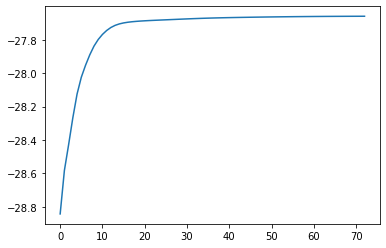

In [20]:
plt.plot(speech_log_likelihood)

TEST 

In [21]:
path_test = './speech_music_classification/test'

In [22]:
files_test = os.listdir(path_test)

In [23]:
window_size = 0.025
shift = 0.010
dft_point = 64
a = 32
b = 2998
total_samples = len(files_test)
test = np.zeros((b * total_samples, a))

In [24]:
# THIS BLOCK OF CODE COMPUTES THE SPECTROGRAM OF ALL THE TEST FILES
# AND STORES ALL THE FRAMES OBTAINED IN MATRIX
for i in range(total_samples):
    freq, signal = wavfile.read(path_test + '/' + files_test[i])
    spec = spectrogram(freq, signal, window_size, shift, dft_point)
    spec = spec.T
    test[b*i:b*(i+1), :] = spec

In [25]:
test.shape

(143904, 32)

In [26]:
# FUNCTION TO FIND THE POSTERIOR PROBABILITY
def posterior_prob(x, means, pis, cov):
    val = 0
    for i in range(pis.shape[0]):
        val += pis[i] * scipy.stats.multivariate_normal(means[i], cov[i], allow_singular=True).pdf(x)
    return val[0]

# FUNCTION TO CHECK WHICH CLASS THE FRAME BELONGS TO
def prediction(posterior_speech, posterior_music):
    if posterior_speech > posterior_music:
        return 'speech'
    else:
        return 'music'

In [27]:
# CONVERT THE SPECTROGRAM MATRIX TO A DATAFRAME 
test = pd.DataFrame(test)

In [28]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,8.295467,8.318956,7.999337,6.964759,6.827860,8.475189,6.470193,8.252470,8.389498,7.621969,...,5.574076,5.432005,5.856495,5.523090,6.458106,6.703065,6.202657,5.058894,3.085059,3.910491
1,5.963892,8.545669,7.530862,7.587834,6.873149,8.250494,7.813603,7.995235,7.143016,7.695573,...,6.459582,6.279313,5.365979,6.067690,6.239443,6.295228,6.250536,6.136141,6.233503,6.223621
2,8.611960,8.002954,8.737158,8.361449,8.101130,7.667582,7.970313,8.077215,8.325011,8.681597,...,4.744833,3.490051,5.027695,4.829357,4.549755,4.233733,5.402216,3.665465,3.143446,2.948704
3,8.848571,8.970658,9.123092,8.198987,7.955693,7.708272,8.599546,8.860717,9.081618,8.776231,...,5.969242,5.911483,5.588607,6.053096,5.846416,5.755054,5.995076,5.817833,5.954871,5.973352
4,9.243228,7.337643,9.134301,8.696931,7.940413,8.081317,8.382841,8.811314,8.858009,8.707364,...,6.881947,6.865155,6.805534,6.699644,6.630863,6.596390,6.461123,6.571342,6.585400,6.485641


In [29]:
# CALCULATE POSTERIOR PROBABILITY AND PREDICT IT'S CLASS FOR EACH TEST SAMPLE
test['posterior_speech'] = test.apply(lambda row: posterior_prob(row[:32], speech_means, speech_pis, speech_cov), axis=1)
test['posterior_music'] = test.apply(lambda row: posterior_prob(row[:32], music_means, music_pis, music_cov), axis=1)
test['predicted'] = test.apply(lambda row: prediction(row.posterior_speech, row.posterior_music), axis=1)

In [30]:
# HERE THE AUDIO SAMPLE WILL BE CLASSIFIED AS MUSIC IF IT HAS MORE NO. OF MUSIC FRAMES THAN SPEECH FRAMES
y = [1]*(total_samples//2)
y.extend([0]* (total_samples//2))
y_pred = []
for i in range(total_samples):
    pred = list(test['predicted'])[b*i: b*(i+1)]
    sp = pred.count('speech')
    mu = pred.count('music')
    if sp > mu:
        y_pred.append(0)
    else:
        y_pred.append(1)

# CALCULATING ACCURACY
true = 0
for i in range(total_samples):
    if y[i] == y_pred[i]:
        true += 1
acc = true/total_samples
acc = acc * 100
print('Accuracy = ' + str(acc))

Accuracy = 97.91666666666666
